### Modules

In [2]:
import tensorflow_addons as tfa
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense,Input,GlobalAveragePooling2D,AveragePooling2D
import datetime
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Data Demo

Found 3602 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0.]


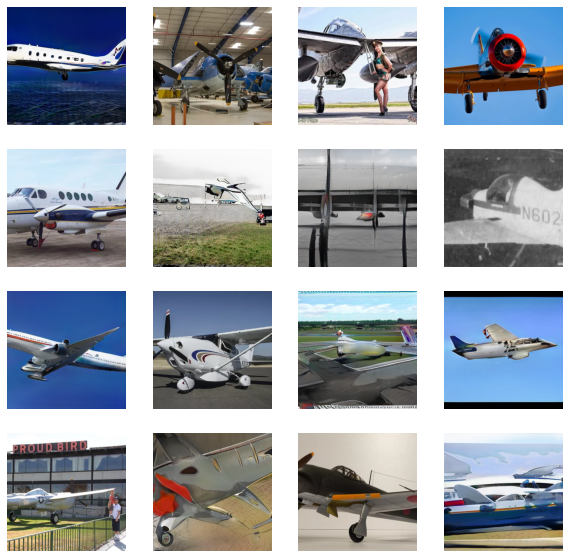

In [14]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.90, rescale = 1./255)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.05, rescale = 1.0/255)
data_dir = '../e4040-proj-data/airplane'
training = img_gen.flow_from_directory(data_dir, subset = 'training' , shuffle = True, 
                                        class_mode = 'binary')
validation = val_gen.flow_from_directory(data_dir, subset = 'validation' , shuffle = True, 
                                         class_mode = 'binary')

#pic size 256*256*3
a,  b= training.next()
print(b)
fig = plt.figure(figsize=(10,10))

for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    ax.imshow(a[i,:].reshape(256,256,3))
    ax.axis('off')

### Hand-Craft ResNet-18

In [15]:
from Network.ResNet import ResNet
import tensorflow_addons as tfa
model = ResNet([2,2,2,2])
model.build(input_shape=(None, 256, 256,3))

### ResNet-18 Demo

In [17]:
optimizer = tf.optimizers.Adam(lr=3e-4)
loss=tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
model.summary()
model.fit(a,b, epochs=30)

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    multiple                  2048      
_________________________________________________________________
sequential_9 (Sequential)    multiple                  148224    
_________________________________________________________________
sequential_10 (Sequential)   multiple                  525952    
_________________________________________________________________
sequential_12 (Sequential)   multiple                  2100480   
_________________________________________________________________
sequential_14 (Sequential)   multiple                  8395264   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0 

KeyboardInterrupt: 

### ResNet-50 from Keras

In [19]:
# Transfer Learning - Tryouts

base_model = applications.resnet50.ResNet50(weights='imagenet', include_top=False,layers=tf.keras.layers)  
#base_model = applications.xception.Xception(weights='imagenet', include_top=False, input_shape=[resize_H,resize_W,channel]) 

for layer in base_model.layers[:140]:  # Keep the pretrained params
    layer.trainable = False
for layer in base_model.layers[140:]:  # Keep the pretrained params
    layer.trainable = True
    
x = base_model.output  # 
x = GlobalAveragePooling2D()(x)  
x = Dense(1024, activation='relu', name='fc1',kernel_regularizer=keras.regularizers.l2(0.0001))(x)  
x = Dropout(0.5)(x)  # Droupout 0.6
x = Dense(512, activation='relu', name='fc2',kernel_regularizer=keras.regularizers.l2(0.0001))(x)
#x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax', name='predictions')(x)  

model = Model(base_model.input,predictions)  

### Hyperparameters

In [20]:
#optimizer = tfa.optimizers.AdamW(lr=3e-4, weight_decay=3e-4)
optimizer = tf.optimizers.Adam()
loss=tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### Tranining Strategies and Implementation

In [22]:
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=4, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='auto')
model.fit(a, b, epochs=30, shuffle = True, batch_size = 8, callbacks=[reduce, early])

Epoch 1/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7068 - accuracy: 0.5625 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7067 - accuracy: 0.3750 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7066 - accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7065 - accuracy: 0.5312 - lr: 0.0010
Epoch 5/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7064 - accuracy: 0.4062 - lr: 0.0010
Epoch 6/30
4/4 [==============================] - 0s 43ms/step - loss: 0.7063 - accuracy: 0.4688 - lr: 0.0010
Epoch 7/30
4/4 [==============================] - 0s 43ms/step - loss: 0.7062 - accuracy: 0.5000 - lr: 0.0010
Epoch 8/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7061 - accuracy: 0.5625 - lr: 0.0010
Epoch 9/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7060 - accuracy: 0.4062 - lr: 0.0010
Epoch 10/3

Epoch 19/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7051 - accuracy: 0.4062 - lr: 0.0010
Epoch 20/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7050 - accuracy: 0.3750 - lr: 0.0010
Epoch 21/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7049 - accuracy: 0.6250 - lr: 0.0010
Epoch 22/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7049 - accuracy: 0.5938 - lr: 0.0010
Epoch 23/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7048 - accuracy: 0.4375 - lr: 0.0010
Epoch 24/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7047 - accuracy: 0.4062 - lr: 0.0010
Epoch 25/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7046 - accuracy: 0.5312 - lr: 0.0010
Epoch 26/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7045 - accuracy: 0.5625 - lr: 0.0010
Epoch 27/30
4/4 [==============================] - 0s 42ms/step - loss: 0.7044 - accuracy: 0.5625 - lr: 0.0010
E